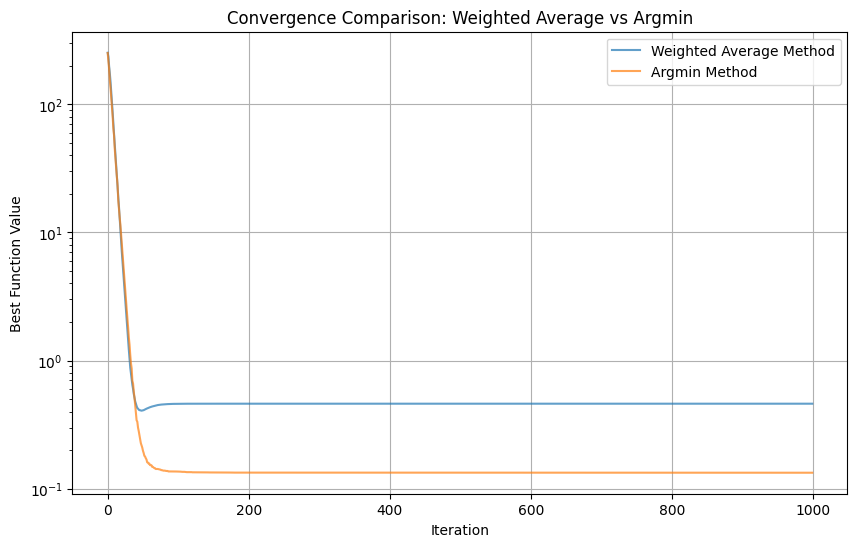

Weighted Average Method:
Best function value: 0.4604071677587761
Mean position: [-0.0176906  -0.14240502 -0.03467108  0.08332376  0.00695368  0.1184252
  0.05207195  0.01358288 -0.1129165  -0.05689737 -0.01081482 -0.18222391
  0.10407451 -0.18151191  0.06865189 -0.07250776 -0.0545943   0.06618375
  0.0189124  -0.06130149 -0.08019911 -0.02192259 -0.09688993 -0.0149012
  0.04031652  0.1300633  -0.13019372 -0.05998004  0.07978648 -0.11658825
 -0.0612658  -0.01343758 -0.01815092 -0.0273313  -0.0946091   0.10195429
  0.00395359 -0.03707606 -0.01934653  0.07737093  0.0210677  -0.17711503
  0.16931326  0.26922028 -0.15195571  0.0889397   0.02400847 -0.01728761
  0.14790893  0.07599609]
Argmin Method:
Best function value: 0.1332677309386612
Mean position: [-0.00844467 -0.08526161 -0.01151329  0.04997919  0.01801544  0.07544215
  0.03906517  0.01593829 -0.05160053 -0.01770177  0.00706171 -0.10376496
  0.05413786 -0.10836413  0.02581117 -0.02353507 -0.02834377  0.03554892
  0.03442842 -0.0424049

In [12]:
import numpy as np
from typing import Callable
import tqdm
import matplotlib.pyplot as plt

class CBOOptimizer:
    def __init__(
        self,
        N: int,
        d: int,
        M: int,
        beta: float,
        lambda_: float,
        sigma: float,
        epsilon: float,
    ):
        self.N = N
        self.d = d
        self.M = M
        self.beta = beta
        self.lambda_ = lambda_
        self.sigma = sigma
        self.epsilon = epsilon
        
    def initialize_particles(self, rho0: Callable) -> np.ndarray:
        return rho0(size=(self.N, self.d))
    
    def create_batches(self, remainder: list) -> tuple:
        all_indices = remainder + list(np.random.permutation(self.N))
        q = len(all_indices) // self.M
        batches = [all_indices[i*self.M:(i+1)*self.M] for i in range(q)]
        new_remainder = all_indices[q*self.M:]
        return batches, new_remainder
    
    def update_weighted_average(self, X: np.ndarray, batch: list, L: Callable) -> np.ndarray:
        """Method 1: Weighted average update"""
        L_values = np.array([L(X[j]) for j in batch])
        weights = np.exp(-self.beta * L_values)
        weights_sum = np.sum(weights)
        
        x_star = np.zeros(self.d)
        for idx, j in enumerate(batch):
            x_star += X[j] * weights[idx]
        
        return x_star / weights_sum
    
    def update_argmin(self, X: np.ndarray, batch: list, L: Callable) -> np.ndarray:
        """Method 2: Argmin update"""
        L_values = np.array([L(X[j]) for j in batch])
        min_idx = batch[np.argmin(L_values)]
        return X[min_idx].copy()
    
    def update_particles(self, X: np.ndarray, x_star: np.ndarray, batch: list, gamma: float, full_update: bool = False) -> np.ndarray:
        update_indices = range(self.N) if full_update else batch
        
        for j in update_indices:
            z = np.random.normal(0, 1, self.d)
            drift = -self.lambda_ * gamma * (X[j] - x_star)
            diffusion = self.sigma * np.sqrt(gamma) * np.multiply(X[j] - x_star, z)
            X[j] = X[j] + drift + diffusion
            
        return X
    
    

def run_cbo(N: int, d: int, M: int, beta: float, lambda_: float, sigma: float, epsilon: float,
            rho0: Callable, L: Callable, method: str = 'weighted_avg', max_iter: int = 1000) -> tuple:
    """Run CBO algorithm with specified update method"""
    optimizer = CBOOptimizer(N, d, M, beta, lambda_, sigma, epsilon)
    X = optimizer.initialize_particles(rho0)
    remainder = []
    
    history = []  # Track best function values
    
    for k in range(max_iter):
        batches, remainder = optimizer.create_batches(remainder)
        
        for batch in batches:
            # Update x_star based on method
            if method == 'weighted_avg':
                x_star = optimizer.update_weighted_average(X, batch, L)
            else:  # argmin
                x_star = optimizer.update_argmin(X, batch, L)
            
            X = optimizer.update_particles(X, x_star, batch, gamma=0.1)
        
        # Track best value
        best_value = min(L(x) for x in X)
        history.append(best_value)
        
        if best_value <= epsilon:
            break
    
    return X, history

# Test function and initial distribution
def rho0(size):
    """Initial distribution - uniform in [-5, 5]"""
    return np.random.uniform(-5, 5, size)

def test_function(x):
    """Test function: sum of squares"""
    return np.sum(x**2)

# Parameters
N = 1000  # number of particles
d = 50    # dimension
M = 10   # batch size
beta = 0.1
lambda_ = 1.0
sigma = 0.1
epsilon = 1e-6
max_iter = 1000

# Run both methods
np.random.seed(42)  # For reproducibility
result_weighted, history_weighted = run_cbo(N, d, M, beta, lambda_, sigma, epsilon, 
                                          rho0, test_function, method='weighted_avg', 
                                          max_iter=max_iter)

np.random.seed(42)  # Reset seed for fair comparison
result_argmin, history_argmin = run_cbo(N, d, M, beta, lambda_, sigma, epsilon, 
                                       rho0, test_function, method='argmin', 
                                       max_iter=max_iter)

# Plot convergence comparison
plt.figure(figsize=(10, 6))
plt.plot(history_weighted, label='Weighted Average Method', alpha=0.7)
plt.plot(history_argmin, label='Argmin Method', alpha=0.7)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Best Function Value')
plt.title('Convergence Comparison: Weighted Average vs Argmin')
plt.legend()
plt.grid(True)
plt.show()

# Print final results
print("\
Weighted Average Method:")
print("Best function value:", min(test_function(x) for x in result_weighted))
print("Mean position:", np.mean(result_weighted, axis=0))

print("\
Argmin Method:")
print("Best function value:", min(test_function(x) for x in result_argmin))
print("Mean position:", np.mean(result_argmin, axis=0))